In [1]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import constants as C
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy.time import Time
from astropy import units as u
import tqdm 
import matplotlib.animation as anim

### 17th Feb:

**Conditional about observations:**

The user gives the latitude and the functions returns if the phenomenon can be see it or not. This using the conditional "altitude > 0 degrees" but with the difference of taking into account the time of observation on the altitude-Azimuth coordinate system; this is the equivalent ofr the conditional of "dec > 90-latitude".   

Alert system's input format: RA, Dec (hmsdms); Latitude, longitude (DMS); militar hour (hms) using J200 
(Reference: https://ztf.uw.edu/alerts/public/)

**About the sing on the coordinates**
 A positive value for North and East, a negative value for South and West. (Reference: https://tnp.uservoice.com/knowledgebase/articles/172110-latitude-longitude-formats-and-conversion)

In [2]:
#Playtime data
lat_obs = '4-35-56-N' 
lon_obs = '74-04-51-W'   
name = ['Aldebaran','Polar Star', 'Antares']
ra_list = ['04h35m55.64s','02h31m19.79s','16h29m24.17s'] 
dec_list = ['+16d30m27.2s','+89d16m10.10s','-26d25m53.56s']
date = '2025-02-17 21:30:00'

#moving time
date_i = '2025-02-17 19:30:00'
date_f = '2025-02-18 07:00:00'
timescale = ['m', 10]

In [3]:
#Convert the DMS format to degrees
def ConvertLaLo(l):
    l_ = l.split('-')
    D = float(l_[0])
    M = float(l_[1])
    S = float(l_[2])
    dir = l_[3]
    r = D + (M/60) + (S/3600)
    if dir=='W' or dir=='S':
        return r*(-1)
    else:
        return r

ConvertLaLo(lon_obs)

-74.08083333333333

In [4]:
def Observations(longitude, latitude, RA, DEC, Date):
    time_obs = Time(Date)
    lat_conv = ConvertLaLo(latitude)
    lon_conv = ConvertLaLo(longitude)
    observer = EarthLocation(lat=lat_conv*u.deg, lon=lon_conv*u.deg)
    Conditionals = []

    for i in range(0,len(RA)):

        celestial_coord = SkyCoord(ra=RA[i], dec=DEC[i]) #mantain the degrees units

        # Calculate the coordenates AltAz for the time and observer
        frame_altaz = AltAz(obstime=time_obs, location=observer)
        altaz_coord = celestial_coord.transform_to(frame_altaz) #Transform for the J200 coordinate system for altaz
    
        # Determinate if its observable (altitude > 0 degrees), return a boolean
        Conditionals.append(altaz_coord.alt > 0*u.deg)

    #Put everything on a dataframe in the format for better reading
    Data = pd.DataFrame([])
    Data.style.set_caption(Date)
    Data['Observable'] = Conditionals
    Data['RA'] = RA
    Data['Dec'] = DEC

    return Data

Observations(lon_obs, lat_obs, ra_list, dec_list, date)

,Observable,RA,Dec
0,True,04h35m55.64s,+16d30m27.2s
1,True,02h31m19.79s,+89d16m10.10s
2,False,16h29m24.17s,-26d25m53.56s


### 21th Feb

Now we need to expand the function for a time slot, establish by the user. With this condition, is necesary to report if its observable. An idea is refreshing the dataframe with a nonsmall step, such we can determine if the function is returning what we want. 

Change the scale of time to UTC and keep the format iso for maintain the international format.

Actually, the function Time of astropy simplifies the code because allows sum seconds, hour and minutes in a line.
(Reference: https://docs.astropy.org/en/stable/api/astropy.time.Time.html#astropy.time.Time.FORMATS)

In [5]:
def MoveTime(time_actual,scale,sc):
    if scale == 's':
        t = time_actual + sc*u.second 
    if scale == 'm':
        t = time_actual + sc*u.minute
    if scale == 'h':
        t = time_actual + sc*u.hour

    return t

MoveTime(Time(date,scale='utc',format='iso'),'h',1)

<Time object: scale='utc' format='iso' value=2025-02-17 22:30:00.000>

In [6]:
#With time slot and optimized

def Observations(longitude, latitude, RA, DEC, Date_i, Date_f,time_scale):
    actual_time = Time(Date_i,format = 'iso', scale='utc')
    final_time = Time(Date_f,format = 'iso', scale='utc')
    lat_conv = ConvertLaLo(latitude)
    lon_conv = ConvertLaLo(longitude)
    observer = EarthLocation(lat=lat_conv*u.deg, lon=lon_conv*u.deg)
    Big_Data = []
    Time_values = []

    while actual_time <= final_time:
        Conditionals = []

        for i in range(0,len(RA)):

            celestial_coord = SkyCoord(ra=RA[i], dec=DEC[i]) #mantain the degrees units

            # Calculate the coordenates AltAz for the time and observer
            frame_altaz = AltAz(obstime=actual_time, location=observer)
            altaz_coord = celestial_coord.transform_to(frame_altaz) #Transform for the J200 coordinate system for altaz
    
            # Determinate if its observable (altitude > 0 degrees), return a boolean
            Conditionals.append(altaz_coord.alt > 0*u.deg)

        #Put everything on a dataframe in the format for better reading
        Data = pd.DataFrame([])
        Data['Observable'] = Conditionals
        Data['RA'] = RA
        Data['Dec'] = DEC
        Big_Data.append(Data) 
        Time_values.append(actual_time)

        actual_time = MoveTime(actual_time,time_scale[0],time_scale[1])

    return Big_Data,Time_values

Data, times = Observations(lon_obs, lat_obs, ra_list, dec_list, date_i, date_f,timescale)

### 24 Feb - 3 Mar
This week have two objectives: 

1) Implemnt a preference condition, just show the observables and organized with preference of higher altitude.

2) Try to simulate for see in the time slot only the observables with the observer as the center. First we need to get the coordinates of the observables in the altaz format.

In [13]:
#With time slot and optimized

def Observations(longitude, latitude, RA, DEC, Date_i, Date_f,time_scale):

    #Definition of different variables:
    actual_time = Time(Date_i,format = 'iso', scale='utc')
    final_time = Time(Date_f,format = 'iso', scale='utc')
    lat_conv = ConvertLaLo(latitude)
    lon_conv = ConvertLaLo(longitude)
    observer = EarthLocation(lat=lat_conv*u.deg, lon=lon_conv*u.deg)

    #Lists of data for post-analysis
    Big_Data = []
    Time_values = []
    Plot_coordinates = []

    #Establish the time slot
    while actual_time <= final_time:

        #For each time slot we need the data of the conditional about observations
        Conditionals = []
        Plot = []
        ra = []
        dec = []

        for i in range(0,len(RA)):

            #Establish the coordinates with the correction from geocentric calculations of astropy
            celestial_coord = SkyCoord(ra=RA[i], dec=DEC[i]) #Mantain the degrees units

            # Calculate the coordenates AltAz for the time and observer
            frame_altaz = AltAz(obstime=actual_time, location=observer)

            #Transform the J2000 coordinate system for altaz
            altaz_coord = celestial_coord.transform_to(frame_altaz) 
    
            # Determinate if its observable (altitude > 0 degrees) in the altaz coordinate system, return a boolean.
            # Only choose the observables
            state = altaz_coord.alt > 0*u.deg
            if state == True:
                Conditionals.append(state)
                ra.append(RA[i])
                dec.append(DEC[i])

            #Put the altaz coordinates for the simulation and identification 
            Plot.append([altaz_coord.az.degree,altaz_coord.alt.degree]) #In a tuple for each object, format: (az,alt) in degrees
            

        #Put the conditionals of a time slot on a dataframe in the format for better reading
        Data = pd.DataFrame([])
        Data['Observable'] = Conditionals
        Data['RA'] = ra
        Data['Dec'] = dec

        #Put the dataframe in a list and the values of time
        Big_Data.append(Data) 
        Time_values.append(actual_time)
        Plot_coordinates.append(Plot)

        #Actualize the time depending of the time scale
        actual_time = MoveTime(actual_time,time_scale[0],time_scale[1])

    return Big_Data,Time_values,Plot_coordinates

Data, times, Plot_c = Observations(lon_obs, lat_obs, ra_list, dec_list, date_i, date_f,timescale)
Data

[   Observable            RA            Dec
 0        True  04h35m55.64s   +16d30m27.2s
 1        True  02h31m19.79s  +89d16m10.10s,
    Observable            RA            Dec
 0        True  04h35m55.64s   +16d30m27.2s
 1        True  02h31m19.79s  +89d16m10.10s,
    Observable            RA            Dec
 0        True  04h35m55.64s   +16d30m27.2s
 1        True  02h31m19.79s  +89d16m10.10s,
    Observable            RA            Dec
 0        True  04h35m55.64s   +16d30m27.2s
 1        True  02h31m19.79s  +89d16m10.10s,
    Observable            RA            Dec
 0        True  04h35m55.64s   +16d30m27.2s
 1        True  02h31m19.79s  +89d16m10.10s,
    Observable            RA            Dec
 0        True  04h35m55.64s   +16d30m27.2s
 1        True  02h31m19.79s  +89d16m10.10s,
    Observable            RA            Dec
 0        True  04h35m55.64s   +16d30m27.2s
 1        True  02h31m19.79s  +89d16m10.10s,
    Observable            RA            Dec
 0        True  04h35m55.

### Simulation and graphic sketch

In [8]:
def EstablishCoord(list_):
    ob =[]
    
    for each_time in list_:
        alt_c = []
        az_c = []
        for each_obj in each_time:
            az_c.append(each_obj[0])
            alt_c.append(each_obj[1])
        ob.append([az_c,alt_c])

    return ob

ob = EstablishCoord(Plot_c)

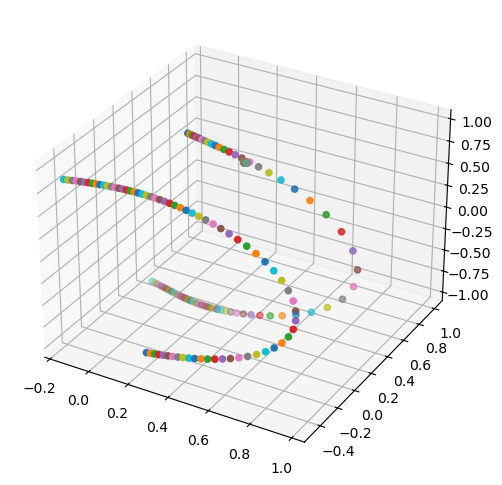

In [11]:
def altaz_to_cartesian(alt, az):
    x = np.cos(alt) * np.sin(az)
    y = np.cos(alt) * np.cos(az)
    z = np.sin(alt)
    return x, y, z

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection = '3d')

for i in range(0,70):
    x, y, z = altaz_to_cartesian(np.radians(ob[i][0]), np.radians(ob[i][1]))
    ax.scatter(x,y,z)

In [10]:
# # Crear la figura 3D
# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111, projection='3d')

# # Configuración del gráfico
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# ax.set_title("Animación de coordenadas AltAz en 3D")

# # Inicializar una lista vacía para almacenar los puntos
# points, = ax.plot([], [], [], 'ro', markersize=8)

# # Función de inicialización de la animación
# def init():
#     points.set_data([], [])
#     points.set_3d_properties([])
#     return points,

# # Función de actualización de la animación
# def update(frame):
#     # Obtener las coordenadas AltAz para el frame actual
#     alt, az = np.radians(ob[frame][0]), np.radians(ob[frame][1])
    
#     # Convertir a coordenadas cartesianas
#     x, y, z = altaz_to_cartesian(alt, az)
    
#     # Actualizar los datos del punto
#     points.set_data([x], [y])
#     points.set_3d_properties([z])
    
#     return points,

# # Crear la animación
# ani = anim.FuncAnimation(fig, update, frames=len(ob), init_func=init, blit=True, interval=500)

# # Mostrar la animación
# plt.show()